## Twitter Sentimental Analysis 

This sentimental analysis is done using 'US_airline_tweets.csv' dataset

In [2]:
#importing required libraries
from matplotlib.pyplot import figure
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
import matplotlib
import warnings

In [3]:
%matplotlib inline
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\CHIT
[nltk_data]     CHAT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data cleaning

clean function is used for data cleaning. It remove special character, stop word, and url from the tweet message. Both regular expression and BeautifulSoup module are used to clean the text. The nltk.corpus.stopword is used to identify stopword. Character @ and # are not yet removed at this stage, because they are used to identify the airline refered in a tweet message.

In [4]:
# Reference to remove url: https://stackoverflow.com/questions/6038061/regular-expression-to-find-urls-within-a-string
def clean(txt):
    # remove html tags
    txt = re.sub(r'/<[^>]+>/', '', txt)
    # remove url
    txt = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?','', txt)
    # remove special characters
    txt = re.sub(r'[^A-Za-z0-9 \s \# \@]+', '', txt)
    # to lower case
    txt = txt.strip().lower()
    # remove stop word
    txt = re.sub(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*', '', txt)
    soup = BeautifulSoup(txt, "html.parser")
    return ''.join(soup.findAll(text=True))

In [6]:
#get_sentiment converts sentiment from text ''positive" and "negative" into a numerical value. 4 means postive sentiment, 
#0 means otherwise.

def get_sentiment(txt): 
    return 4 if txt.lower() == 'positive' else 0

### Cleaning the Airline tweet message

In [18]:
airline_twt_combined = ''
df_airline_twt = pd.read_csv('US_airline_tweets.csv')
airline_cleaned_twt = []

for index, row in df_airline_twt.iterrows():
    twt_cleaned = clean(row['text'])
    airline_twt_combined += ' ' + twt_cleaned
    airline_cleaned_twt.append(twt_cleaned)
    df_airline_twt.loc[index, 'sentiment'] = get_sentiment(row['sentiment'])

In [19]:
df_airline_twt.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,4,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,0,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,0,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,0,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,4,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


## Exploratory Analysis

### Determine what Airline Associated with the tweet

In [16]:
def get_hash_tags(tw): #helper function to retrieve all hash tags from a tweet.
    p = re.compile('\#([a-zA-Z]*)')
    return p.findall(tw)

# A list contains all the airline name in the most basic fashion
airline_names = ['united', 'delta', 'southwest', 'jetblue', 'american',\
                 'spirit', 'suncountry', 'virginamerica', 'usairway', 'us airway',\
                'hawaiian airlines', 'alaska airlines']

def get_airline_from_twt(tw):  #helper function to determine what airlines are mentioned in one tweet. The search is done by 
    #checking if name of airlines are mention with character '@' or '#'. If multiple airlines are mentioned in one tweet,
    #all of them will be returned in a list.
    
    p = re.compile('\@[a-zA-Z]*')
    matches = p.findall(tw)
    airlines = []
    for match in matches:
        for name in airline_names:
            if name in match and name not in airlines:
                airlines.append(name)
    matches = get_hash_tags(tw)
    for match in matches:
        for name in airline_names:
            if name in match and name not in airlines:
                airlines.append(name)
    return airlines

#def get_airline_from_user(username): #helper function to determine if the user/author is related to a airline.
    #for name in airline_names:
       # if name in username.lower():
            #return [name]
   # return []

> Next, Determine what airlines are associated with the tweet message by checking @, # and tweet author.
> Count the occurrence of airline names in the message and record if the sentiment is positive or not. 
    If multiple airlines are mentioned in one tweet, all of them are recorded.

In [17]:
airline_count = {}
airlines_ = []
cnt_no_airline_found = 0
for index, row in df_airline_twt.iterrows(): #iterate over dataframe rows as (index, Series) pairs.
    airlines = get_airline_from_twt(airline_cleaned_twt[index])
    if not airlines: 
      airlines = get_airline_from_user(row['user'])
    if not airlines:
      cnt_no_airline_found += 1
    airlines_.append(airlines)
    for airline in airlines:
        sentiment = row['sentiment']
        if airline not in airline_count:
            airline_count[airline] = {4:0, 0:0}
        airline_count[airline][sentiment] += 1
print('Fails to extract airline from %d tweets'% cnt_no_airline_found)
print(airline_count)

Fails to extract airline from 0 tweets
{'virginamerica': {4: 152, 0: 190}, 'southwest': {4: 574, 0: 1219}, 'jetblue': {4: 546, 0: 969}, 'united': {4: 497, 0: 2672}, 'american': {4: 354, 0: 2106}, 'delta': {4: 4, 0: 71}, 'usairway': {4: 275, 0: 2319}, 'spirit': {4: 2, 0: 8}}


 From the above result, we can say that, There are 8 different airlines found from the the US airline tweet dataset. The United airline is mentioned in 3142 tweet, which is more than any other airlines. The Spirit airline is only mentioned in 10 tweet, and it is the least mentioned airline in this data set. Generally speaking, there are more negative sentiment tweet than positive one.

### Plotting Wordcloud

In [20]:
#Tokenizing the tweets
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+')
airline_tokenized = tokenizer.tokenize(airline_twt_combined)

In [21]:
#Finding 100 most frequntly used words
airline_freq_dist = nltk.FreqDist(airline_tokenized)
airline_common_word = airline_freq_dist.most_common(100)

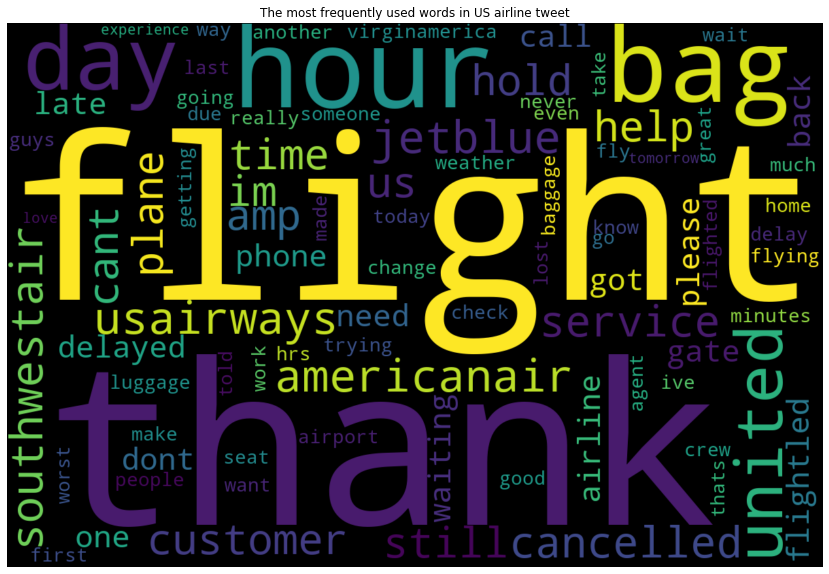

In [33]:
#Building wordcloud
from wordcloud import WordCloud

airline_space_separated = ' '.join(w[0] for w in airline_common_word)
airline_wordcloud = WordCloud(width = 1200, height = 800).generate(airline_space_separated)


plt.figure(figsize=(20,10))
plt.imshow(airline_wordcloud, interpolation='bilinear')
plt.title('The most frequently used words in US airline tweet')
plt.axis("off")
plt.show()

In [24]:
#Plotting a grouped bar chart to descripe the number of positive and negative tweet message associated with each airline.

name = []
positive_cnt = []
negative_cnt = []

for key in airline_count.keys():
    name.append(key)
    positive_cnt.append(airline_count[key][4])
    negative_cnt.append(airline_count[key][0])


In [25]:
# Reference: https://web.archive.org/web/20170228011551/http://matplotlib.org/examples/api/barchart_demo.html
# This function is modified based on the one privided in matplotlib documentation shown above.

def autolabel(rects, isfloat=False):
    """
    Attach a text label above each bar displaying its height
    """
    if isfloat:
      for rect in rects:
          height = rect.get_height()
          ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                  '%.2f' % float(height),
                  ha='center', va='bottom')
    else:
      for rect in rects:
          height = rect.get_height()
          ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                  '%d' % int(height),
                  ha='center', va='bottom')

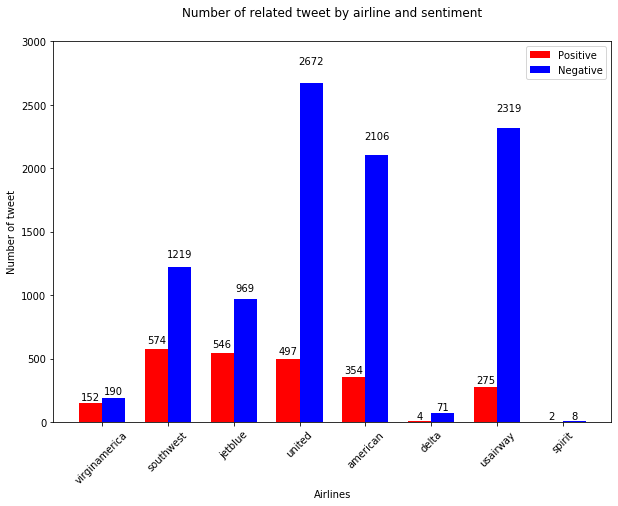

In [32]:
fig, ax = plt.subplots(figsize=(10,7))

ind = np.arange(len(name))
width = 0.35

p1 = ax.bar(ind,positive_cnt,width,color='r')
p2 = ax.bar(ind+width,negative_cnt,width,color='b')

autolabel(p1)
autolabel(p2)

ax.set_title('Number of related tweet by airline and sentiment',y=1.05)
ax.set_ylabel('Number of tweet')
ax.set_xlabel('Airlines')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(name)
ax.set_ylim(0,3000)

ax.legend((p1[0], p2[0]), ('Positive', 'Negative'))

plt.xticks(rotation=45)
plt.show()

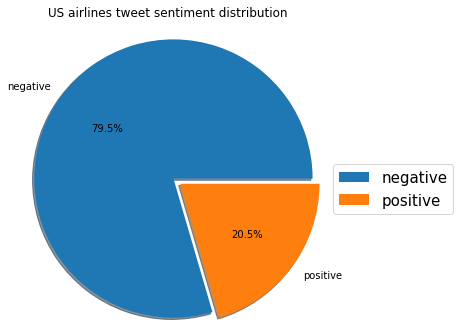

In [42]:
#US airlines tweet sentiment distribution
labels = ['negative', 'positive']
values=df_airline_twt.sentiment.value_counts()
plt.suptitle("US airlines tweet sentiment distribution",  y=1.1)
wedges, plt_labels, junk  = plt.pie(values,labels=labels,autopct='%1.1f%%',\
                                    explode=[0,0.1],radius=1.6,shadow=True)
plt.legend(wedges, labels, bbox_to_anchor=(1.2,0.6),prop={'size':15})